In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import json
import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# from keras.preprocessing import text
from tensorflow.keras.preprocessing import text
# from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments, TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
# from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer


In [59]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/output2.json'

intents = load_json_file(filename)

In [60]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [61]:
def extract_json_info(json_file, df):

    for intent in json_file:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [62]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [63]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 1543 rows and 2 columns


In [64]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 1543 entries, 0 to 1542
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  1543 non-null   object
 1   Tag      1543 non-null   object
dtypes: object(2)
memory usage: 36.2+ KB
None


In [65]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 77 classes


In [66]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


In [67]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

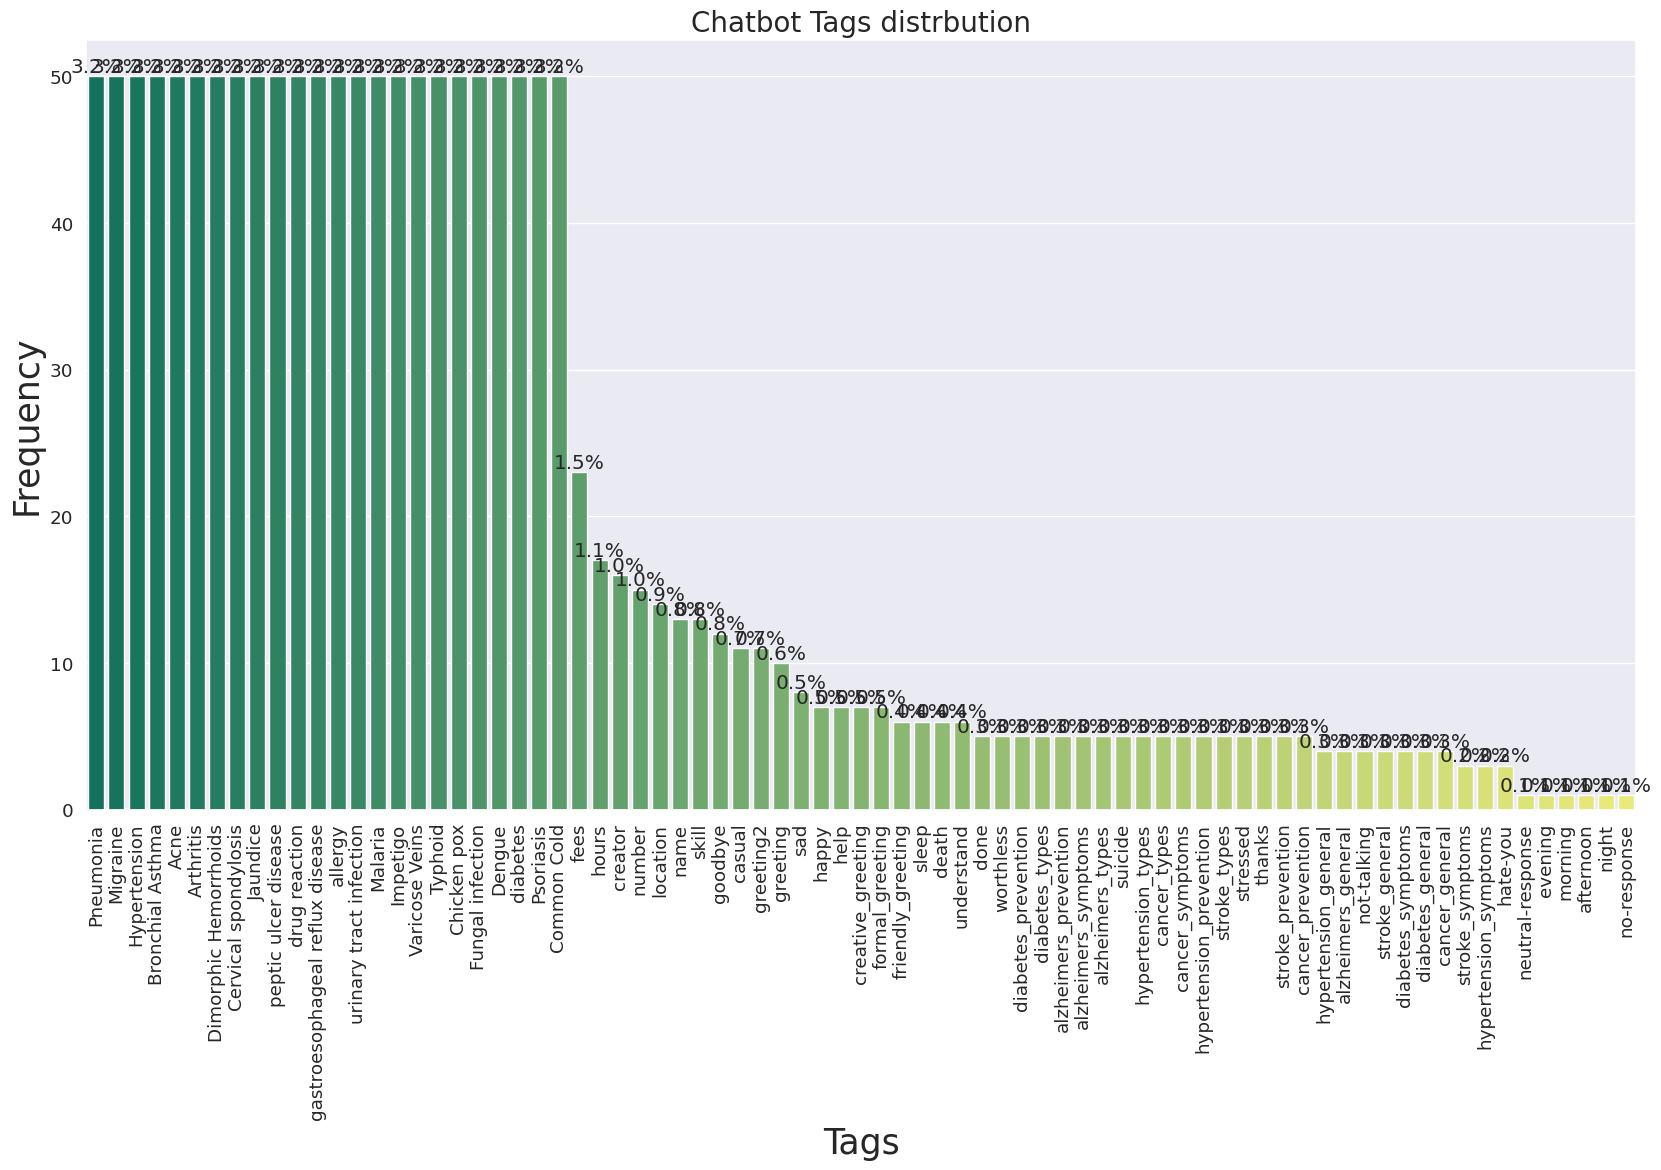

In [68]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [69]:
import nltk

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [70]:
df.head()

,Pattern,Tag
0,i have been experienc a skin rash on my arm le...,Psoriasis
1,my skin ha been peel especi on my knee elbow a...,Psoriasis
2,i have been experienc joint pain in my finger ...,Psoriasis
3,there is a silver like dust on my skin especi ...,Psoriasis
4,my nail have small dent or pit in them and the...,Psoriasis


In [71]:
print(df['Pattern'].isnull().sum())

0


In [72]:
df2.head()

,Pattern,Tag
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [73]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['Psoriasis',
 'Varicose Veins',
 'Typhoid',
 'Chicken pox',
 'Impetigo',
 'Dengue',
 'Fungal infection',
 'Common Cold',
 'Pneumonia',
 'Dimorphic Hemorrhoids',
 'Arthritis',
 'Acne',
 'Bronchial Asthma',
 'Hypertension',
 'Migraine',
 'Cervical spondylosis',
 'Jaundice',
 'Malaria',
 'urinary tract infection',
 'allergy',
 'gastroesophageal reflux disease',
 'drug reaction',
 'peptic ulcer disease',
 'diabetes',
 'cancer_general',
 'cancer_types',
 'cancer_symptoms',
 'cancer_prevention',
 'diabetes_general',
 'diabetes_types',
 'diabetes_symptoms',
 'diabetes_prevention',
 'alzheimers_general',
 'alzheimers_types',
 'alzheimers_symptoms',
 'alzheimers_prevention',
 'hypertension_general',
 'hypertension_types',
 'hypertension_symptoms',
 'hypertension_prevention',
 'stroke_general',
 'stroke_types',
 'stroke_symptoms',
 'stroke_prevention',
 'morning',
 'afternoon',
 'evening',
 'night',
 'thanks',
 'no-response',
 'neutral-response',
 'skill',
 'help',
 'sad',
 'stressed',
 'greeti

In [74]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [75]:
id2label

{0: 'Psoriasis',
 1: 'Varicose Veins',
 2: 'Typhoid',
 3: 'Chicken pox',
 4: 'Impetigo',
 5: 'Dengue',
 6: 'Fungal infection',
 7: 'Common Cold',
 8: 'Pneumonia',
 9: 'Dimorphic Hemorrhoids',
 10: 'Arthritis',
 11: 'Acne',
 12: 'Bronchial Asthma',
 13: 'Hypertension',
 14: 'Migraine',
 15: 'Cervical spondylosis',
 16: 'Jaundice',
 17: 'Malaria',
 18: 'urinary tract infection',
 19: 'allergy',
 20: 'gastroesophageal reflux disease',
 21: 'drug reaction',
 22: 'peptic ulcer disease',
 23: 'diabetes',
 24: 'cancer_general',
 25: 'cancer_types',
 26: 'cancer_symptoms',
 27: 'cancer_prevention',
 28: 'diabetes_general',
 29: 'diabetes_types',
 30: 'diabetes_symptoms',
 31: 'diabetes_prevention',
 32: 'alzheimers_general',
 33: 'alzheimers_types',
 34: 'alzheimers_symptoms',
 35: 'alzheimers_prevention',
 36: 'hypertension_general',
 37: 'hypertension_types',
 38: 'hypertension_symptoms',
 39: 'hypertension_prevention',
 40: 'stroke_general',
 41: 'stroke_types',
 42: 'stroke_symptoms',
 43:

In [76]:
label2id

{'Psoriasis': 0,
 'Varicose Veins': 1,
 'Typhoid': 2,
 'Chicken pox': 3,
 'Impetigo': 4,
 'Dengue': 5,
 'Fungal infection': 6,
 'Common Cold': 7,
 'Pneumonia': 8,
 'Dimorphic Hemorrhoids': 9,
 'Arthritis': 10,
 'Acne': 11,
 'Bronchial Asthma': 12,
 'Hypertension': 13,
 'Migraine': 14,
 'Cervical spondylosis': 15,
 'Jaundice': 16,
 'Malaria': 17,
 'urinary tract infection': 18,
 'allergy': 19,
 'gastroesophageal reflux disease': 20,
 'drug reaction': 21,
 'peptic ulcer disease': 22,
 'diabetes': 23,
 'cancer_general': 24,
 'cancer_types': 25,
 'cancer_symptoms': 26,
 'cancer_prevention': 27,
 'diabetes_general': 28,
 'diabetes_types': 29,
 'diabetes_symptoms': 30,
 'diabetes_prevention': 31,
 'alzheimers_general': 32,
 'alzheimers_types': 33,
 'alzheimers_symptoms': 34,
 'alzheimers_prevention': 35,
 'hypertension_general': 36,
 'hypertension_types': 37,
 'hypertension_symptoms': 38,
 'hypertension_prevention': 39,
 'stroke_general': 40,
 'stroke_types': 41,
 'stroke_symptoms': 42,
 'st

In [77]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,I have been experiencing a skin rash on my arm...,Psoriasis,0
1,"My skin has been peeling, especially on my kne...",Psoriasis,0
2,I have been experiencing joint pain in my fing...,Psoriasis,0
3,"There is a silver like dusting on my skin, esp...",Psoriasis,0
4,"My nails have small dents or pits in them, and...",Psoriasis,0


In [78]:
X = list(df2['Pattern'])
X[:5]

['I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.',
 'My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation.',
 'I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and throbbing, and it gets worse when I move my joints.',
 'There is a silver like dusting on my skin, especially on my lower back and scalp. This dusting is made up of small scales that flake off easily when I scratch them.',
 'My nails have small dents or pits in them, and they often feel inflammatory and tender to the touch. Even there are minor rashes on my arms.']

In [79]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [81]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [83]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [84]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [85]:
full_data = tokenizer(X, truncation=True, padding=True)

In [86]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [87]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [88]:
fullDataLoader = DataLoader(full_data, y_test)

In [89]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [90]:
training_args = TrainingArguments(
    output_dir='./ChatBot',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [91]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [92]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,4.156600,3.866216,0.108808,0.024040,0.018090,0.059129
100,3.392600,2.830293,0.520725,0.221354,0.260069,0.256974
150,2.162200,1.599570,0.774611,0.391975,0.381336,0.439039
200,1.161600,0.945387,0.844560,0.462579,0.461189,0.502925
250,0.694200,0.695018,0.852332,0.459172,0.444656,0.501059
300,0.459000,0.547490,0.883420,0.538050,0.553817,0.560776
350,0.333100,0.435654,0.917098,0.614959,0.610316,0.642147
400,0.231600,0.381352,0.904145,0.638963,0.653059,0.662032
450,0.155300,0.334860,0.919689,0.634047,0.642625,0.655058
500,0.109700,0.294783,0.930052,0.656407,0.656656,0.681320


TrainOutput(global_step=3700, training_loss=0.1814497183263302, metrics={'train_runtime': 1847.5447, 'train_samples_per_second': 62.624, 'train_steps_per_second': 2.003, 'total_flos': 4640763646818000.0, 'train_loss': 0.1814497183263302, 'epoch': 100.0})

In [93]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.009579,1.000000,1.000000,1.000000,1.000000
test,0.250040,0.937824,0.687416,0.700035,0.694729


In [94]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda") # Change to "cpu"
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [95]:
text = "Hello"
predict(text)

(tensor([[9.6895e-05, 8.5063e-05, 9.6560e-05, 1.6185e-04, 2.0600e-04, 1.5129e-04,
          1.4141e-04, 2.2615e-04, 5.3551e-05, 7.8151e-05, 2.4026e-04, 1.1642e-04,
          9.3965e-05, 1.1627e-04, 1.3769e-04, 7.9017e-05, 6.8014e-05, 7.3417e-05,
          2.8702e-05, 1.0303e-04, 3.5440e-05, 4.6379e-05, 6.0674e-05, 3.9708e-04,
          1.2684e-04, 1.1502e-04, 1.3664e-04, 8.2641e-05, 3.0426e-05, 1.6705e-05,
          3.1622e-04, 6.7474e-05, 6.1627e-05, 1.9502e-04, 5.2922e-05, 3.3159e-05,
          1.7263e-04, 9.4656e-05, 2.0394e-04, 3.6385e-05, 1.4354e-04, 1.2302e-04,
          9.9312e-05, 4.1977e-05, 6.1001e-04, 9.7168e-05, 1.1968e-04, 6.8042e-05,
          4.1322e-05, 1.1489e-04, 1.0508e-04, 1.5112e-04, 1.8745e-04, 5.4677e-05,
          2.4627e-04, 9.8669e-01, 3.7333e-04, 1.1604e-04, 6.2772e-04, 2.2872e-04,
          1.3250e-04, 9.5354e-05, 7.9116e-04, 2.6877e-04, 4.4764e-04, 8.5712e-04,
          1.7520e-04, 1.9149e-04, 1.9648e-04, 1.0108e-04, 1.5858e-04, 4.7822e-05,
          1.4876

In [96]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [113]:
model_path = "/content/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [114]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9866862297058105}]

In [115]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        label = label2id[chatbot(text)[0]['label']]

        score = chatbot(text)[0]['score']
        if label >=0 and label <= 23:
          response = random.choice(intents[label]['responses'])
          print(f"Chatbot: {response}\n")
          print(f"The probability of accuracy of this diagnosis is {score}\n\n")
          text = input("User: ").strip().lower()
          continue

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        # label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents[label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [116]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: hi
Chatbot: Hi there, how can I help?


User: can you help me?
Chatbot: Tell me your problem so that i can assist you


User: what can you do
Chatbot: I can provide general advice regarding anxiety and depression, answer questions related to mental health and make daily conversations. Do not consider me as a subsitute for an actual mental healthcare worker. and I can also diagnose all types of blood diseases and cancer based on your symptoms. (Note: You must be supervised by a specialist doctor). Please seek help if you don't feel satisfied with me.


User: i feel Chills Headache Sweats Fatigue Nausea and vomiting Body aches.
Chatbot: These are the symptoms of Dengue.

The probability of accuracy of this diagnosis is 0.4942787289619446


User: Severe malaria can cause multi-organ failure in adults, while children frequently su

In [119]:
import shutil
from google.colab import files

# Replace 'your_folder' with the name of your folder
shutil.make_archive('/content/chatbot', 'zip', '/content/chatbot')

# Download the zip file
files.download('/content/chatbot.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>